In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from pytorch_katas.settings import DATA_DIR

# Preparation

In [3]:
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_dataset = datasets.Food101(root=DATA_DIR, split="train", transform=train_transform, download=True)
test_dataset = datasets.Food101(root=DATA_DIR, split="test", transform=val_transform, download=True)

print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")

Train: 75750, Test: 25250
Number of classes: 101


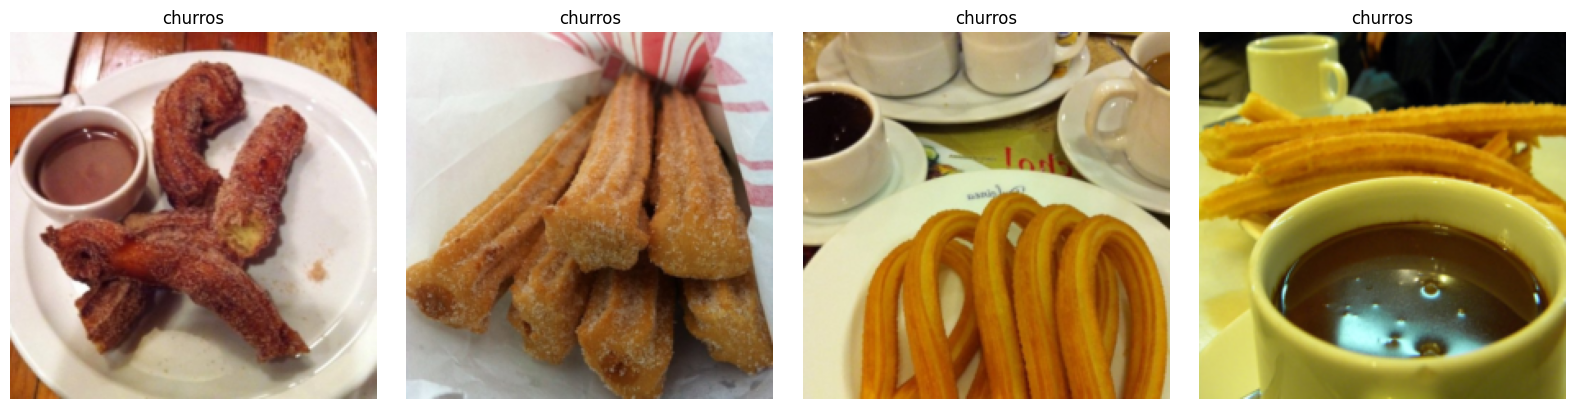

In [4]:
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    img = img * std + mean
    img = img.clamp(0, 1)
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(train_dataset.classes[label])
    ax.axis("off")
plt.tight_layout()
plt.show()

# Kata

Implement a simple Resnet (https://arxiv.org/pdf/1512.03385)
# ![Single block](resnet_block.png)
# ![ResNet Overview](overview.png)




In [5]:
dl = DataLoader(train_dataset, batch_size=4, shuffle=True)
batch = next(iter(dl))

print(f"Data shape: {batch[0].shape}")  # images
print(f"Label shape: {batch[1].shape}")  # labels

Data shape: torch.Size([4, 3, 224, 224])
Label shape: torch.Size([4])


In [52]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.projection = (
            nn.Identity()
            if in_channels == out_channels
            else nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=2)
        )

        self.module = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                stride=1 if in_channels == out_channels else 2,
                padding=1,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        print(x.shape)
        return F.relu(self.projection(x) + self.module(x))


class ResNetStage(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, n_blocks: int):
        super().__init__()
        self.blocks = nn.ModuleList(
            [ResNetBlock(in_channels=in_channels, out_channels=out_channels)]
            + [ResNetBlock(in_channels=out_channels, out_channels=out_channels)] * (n_blocks - 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for block in self.blocks:
            x = block(x)
        return x


class ResNet18(nn.Module):
    def __init__(self, block_config: tuple[int] = (2, 2, 2, 2), base_channels: int = 64, n_classes=101):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=base_channels, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.stages = nn.ModuleList(
            [ResNetStage(in_channels=base_channels, out_channels=base_channels, n_blocks=block_config[0])] + 
            [
                ResNetStage(
                    in_channels=base_channels * (2**i), out_channels=base_channels * (2 ** (i + 1)), n_blocks=n_blocks
                )
                for i, n_blocks in enumerate(block_config[1:])
            ]
        )

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=base_channels * (2 ** (len(block_config) -1)), out_features=n_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.stem(x)
        for i, stage in enumerate(self.stages):
            print(f"stage {i}")
            x = stage(x)
        return self.head(x)

In [53]:
m = ResNet18()
t = torch.randn(1, 3, 224, 224)
out = m(t)

stage 0
torch.Size([1, 64, 56, 56])
torch.Size([1, 64, 56, 56])
stage 1
torch.Size([1, 64, 56, 56])
torch.Size([1, 128, 28, 28])
stage 2
torch.Size([1, 128, 28, 28])
torch.Size([1, 256, 14, 14])
stage 3
torch.Size([1, 256, 14, 14])
torch.Size([1, 512, 7, 7])


In [54]:
out.shape

torch.Size([1, 101])